# Model 1: CNN Base (From Scratch)
## Pneumonia Classification with 3-Fold Cross-Validation + Ensemble Prediction

**Architecture:** VGG-like CNN trained from scratch
- 3 convolutional blocks (32 → 64 → 128 filters)
- BatchNorm + ReLU + MaxPooling + Dropout
- Global Average Pooling → Dense(128) → Dense(1, sigmoid)

**Optimizations for 4GB VRAM:**
- Image size: 128×128
- Batch size: 8
- Mixed precision training

**Ensemble Strategy:** Average predictions from all 3 folds

## 1. Setup & Configuration

In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_curve
)
import json
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. GPU Memory Configuration

In [3]:
# Configure GPU memory growth to avoid OOM
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"Memory growth error: {e}")

# Enable mixed precision for memory efficiency
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print(f"Mixed precision policy: {tf.keras.mixed_precision.global_policy()}")

Memory growth enabled for 1 GPU(s)
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6
Mixed precision policy: <Policy "mixed_float16">


## 3. Configuration Parameters

In [4]:
# Paths
BASE_DIR = Path('chest_xray')
TRAIN_DIR = BASE_DIR / 'train'
VAL_DIR = BASE_DIR / 'val'
TEST_DIR = BASE_DIR / 'test'

# Training parameters - Optimized for 4GB VRAM
IMG_SIZE = 128  # Reduced from 224 for memory
BATCH_SIZE = 8  # Small batch for limited VRAM
EPOCHS = 20     # Reduced from 40
N_FOLDS = 3     # 3-fold cross-validation
PATIENCE = 5    # Early stopping patience
RANDOM_STATE = 42

# Class names
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']
CLASS_MAP = {'NORMAL': 0, 'PNEUMONIA': 1}

print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Max Epochs: {EPOCHS}")
print(f"CV Folds: {N_FOLDS}")
print(f"Early Stopping Patience: {PATIENCE}")

Image Size: 128x128
Batch Size: 8
Max Epochs: 20
CV Folds: 3
Early Stopping Patience: 5


## 4. Data Loading (Combine Train + Val)

In [5]:
def load_data_paths(directories):
    """Load image paths and labels from multiple directories."""
    image_paths = []
    labels = []
    
    for directory in directories:
        for class_name in CLASS_NAMES:
            class_dir = directory / class_name
            if class_dir.exists():
                for img_path in class_dir.glob('*'):
                    if img_path.suffix.lower() in ['.jpeg', '.jpg', '.png']:
                        image_paths.append(str(img_path))
                        labels.append(CLASS_MAP[class_name])
    
    return np.array(image_paths), np.array(labels)

# Combine train and val (val has only 16 images)
train_val_paths, train_val_labels = load_data_paths([TRAIN_DIR, VAL_DIR])
test_paths, test_labels = load_data_paths([TEST_DIR])

print(f"\nCombined Train+Val: {len(train_val_paths)} images")
print(f"  - Normal: {np.sum(train_val_labels == 0)}")
print(f"  - Pneumonia: {np.sum(train_val_labels == 1)}")
print(f"\nTest Set: {len(test_paths)} images")
print(f"  - Normal: {np.sum(test_labels == 0)}")
print(f"  - Pneumonia: {np.sum(test_labels == 1)}")


Combined Train+Val: 5232 images
  - Normal: 1349
  - Pneumonia: 3883

Test Set: 624 images
  - Normal: 234
  - Pneumonia: 390


## 5. Data Preprocessing & Augmentation

In [6]:
def create_dataset(paths, labels, batch_size, augment=False, shuffle=True):
    """Create a tf.data.Dataset with optional augmentation."""
    
    def load_image(path, label):
        def _load(path):
            img = tf.io.read_file(path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
            img = tf.cast(img, tf.float32) / 255.0
            return img
        return _load(path), label
    
    def augment_image(img, label):
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
        if tf.random.uniform([]) > 0.5:
            img = tf.image.rot90(img, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
        crop_size = tf.random.uniform([], int(IMG_SIZE*0.85), IMG_SIZE, dtype=tf.int32)
        img = tf.image.random_crop(img, [crop_size, crop_size, 3])
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = tf.clip_by_value(img, 0.0, 1.0)
        return img, label
    
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(paths), seed=RANDOM_STATE)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

print("Dataset functions defined.")

Dataset functions defined.


## 6. CNN Model Architecture (From Scratch)

In [7]:
def create_cnn_model():
    """Create VGG-like CNN from scratch."""
    
    model = models.Sequential([
        layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        
        # Block 1: 32 filters
        layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Block 2: 64 filters
        layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Block 3: 128 filters
        layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Classification head
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, kernel_initializer='he_normal',
                     kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        
        # Output layer (float32 for numerical stability with mixed precision)
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ])
    
    return model

# Create and display model
model = create_cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128, 128, 32)      0

## 7. Training with 3-Fold Cross-Validation

In [8]:
# Compute class weights for imbalanced dataset
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_val_labels),
    y=train_val_labels
)
class_weights = {i: w for i, w in enumerate(class_weights_array)}
print(f"Class weights: {class_weights}")

Class weights: {0: 1.939214232765011, 1: 0.6737058975019315}


In [9]:
# 3-Fold Cross-Validation
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Storage for results
fold_results = []
fold_histories = []
all_val_preds = []
all_val_labels = []

# Start total training time
total_start_time = time.time()

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_paths, train_val_labels)):
    print(f"\n{'='*60}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*60}")
    
    fold_start_time = time.time()
    
    # Split data
    X_train, X_val = train_val_paths[train_idx], train_val_paths[val_idx]
    y_train, y_val = train_val_labels[train_idx], train_val_labels[val_idx]
    
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    
    # Create datasets
    train_dataset = create_dataset(X_train, y_train, BATCH_SIZE, augment=True, shuffle=True)
    val_dataset = create_dataset(X_val, y_val, BATCH_SIZE, augment=False, shuffle=False)
    
    # Clear session and create fresh model
    tf.keras.backend.clear_session()
    model = create_cnn_model()
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    
    # Callbacks
    fold_callbacks = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    # Train
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=fold_callbacks,
        verbose=1
    )
    
    # Store history
    fold_histories.append(history.history)
    
    # Evaluate on validation fold
    val_preds_proba = model.predict(val_dataset, verbose=0)
    val_preds = (val_preds_proba > 0.5).astype(int).flatten()
    
    all_val_preds.extend(val_preds)
    all_val_labels.extend(y_val)
    
    # Calculate fold metrics
    fold_acc = accuracy_score(y_val, val_preds)
    fold_auc = roc_auc_score(y_val, val_preds_proba)
    fold_precision = precision_score(y_val, val_preds)
    fold_recall = recall_score(y_val, val_preds)
    fold_f1 = f1_score(y_val, val_preds)
    
    fold_time = time.time() - fold_start_time
    
    fold_results.append({
        'fold': fold + 1,
        'accuracy': fold_acc,
        'auc': fold_auc,
        'precision': fold_precision,
        'recall': fold_recall,
        'f1': fold_f1,
        'training_time': fold_time
    })
    
    print(f"\nFold {fold + 1} Results:")
    print(f"  Accuracy: {fold_acc:.4f}")
    print(f"  AUC: {fold_auc:.4f}")
    print(f"  Precision: {fold_precision:.4f}")
    print(f"  Recall: {fold_recall:.4f}")
    print(f"  F1-Score: {fold_f1:.4f}")
    print(f"  Training Time: {fold_time:.2f}s ({fold_time/60:.2f} min)")
    
    # Save model from each fold
    model.save(f'model_1_cnn_fold_{fold+1}.keras')
    print(f"  Model saved: model_1_cnn_fold_{fold+1}.keras")

# Total training time
total_training_time = time.time() - total_start_time
print(f"\n{'='*60}")
print(f"TOTAL TRAINING TIME: {total_training_time:.2f}s ({total_training_time/60:.2f} min)")
print(f"{'='*60}")


FOLD 1/3
Training samples: 3488
Validation samples: 1744
Epoch 1/20
436/436 [==============================] - 22s 37ms/step - loss: 0.5134 - accuracy: 0.7841 - auc: 0.8590 - val_loss: 0.5564 - val_accuracy: 0.7632 - val_auc: 0.9467 - lr: 0.0010
Epoch 2/20
436/436 [==============================] - 13s 30ms/step - loss: 0.4433 - accuracy: 0.8036 - auc: 0.8919 - val_loss: 0.6137 - val_accuracy: 0.6869 - val_auc: 0.8436 - lr: 0.0010
Epoch 3/20
436/436 [==============================] - 13s 30ms/step - loss: 0.4041 - accuracy: 0.8277 - auc: 0.9103 - val_loss: 0.4414 - val_accuracy: 0.7942 - val_auc: 0.9641 - lr: 0.0010
Epoch 4/20
436/436 [==============================] - 14s 33ms/step - loss: 0.3693 - accuracy: 0.8374 - auc: 0.9238 - val_loss: 0.3192 - val_accuracy: 0.8532 - val_auc: 0.9523 - lr: 0.0010
Epoch 5/20
436/436 [==============================] - 14s 32ms/step - loss: 0.3470 - accuracy: 0.8426 - auc: 0.9324 - val_loss: 0.7039 - val_accuracy: 0.7425 - val_auc: 0.9747 - lr: 0.00

## 8. Training Curves Visualization

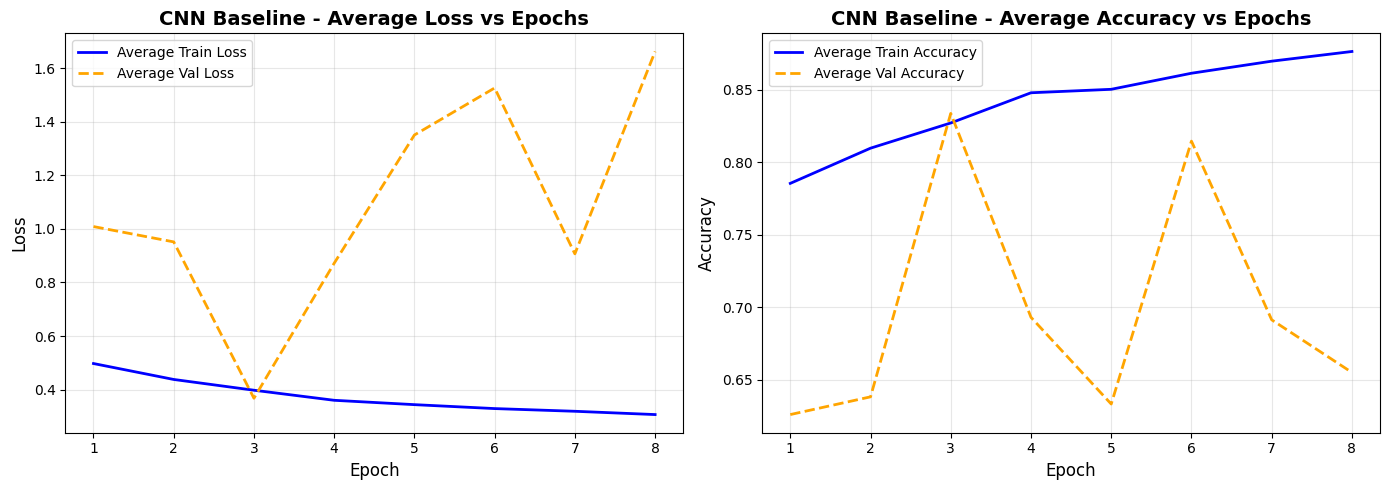

Training curves saved: model_1_cnn_training_curves.png


In [10]:
# Plot Average Loss & Accuracy curves
def get_avg_history(histories, metric):
    min_len = min([len(h[metric]) for h in histories])
    values = [h[metric][:min_len] for h in histories]
    return np.mean(values, axis=0), range(1, min_len+1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
avg_loss, eps = get_avg_history(fold_histories, 'loss')
avg_val_loss, _ = get_avg_history(fold_histories, 'val_loss')
axes[0].plot(eps, avg_loss, label='Average Train Loss', linewidth=2, color='blue')
axes[0].plot(eps, avg_val_loss, '--', label='Average Val Loss', linewidth=2, color='orange')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('CNN Baseline - Average Loss vs Epochs', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
avg_acc, _ = get_avg_history(fold_histories, 'accuracy')
avg_val_acc, _ = get_avg_history(fold_histories, 'val_accuracy')
axes[1].plot(eps, avg_acc, label='Average Train Accuracy', linewidth=2, color='blue')
axes[1].plot(eps, avg_val_acc, '--', label='Average Val Accuracy', linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('CNN Baseline - Average Accuracy vs Epochs', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_1_cnn_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print('Training curves saved: model_1_cnn_training_curves.png')

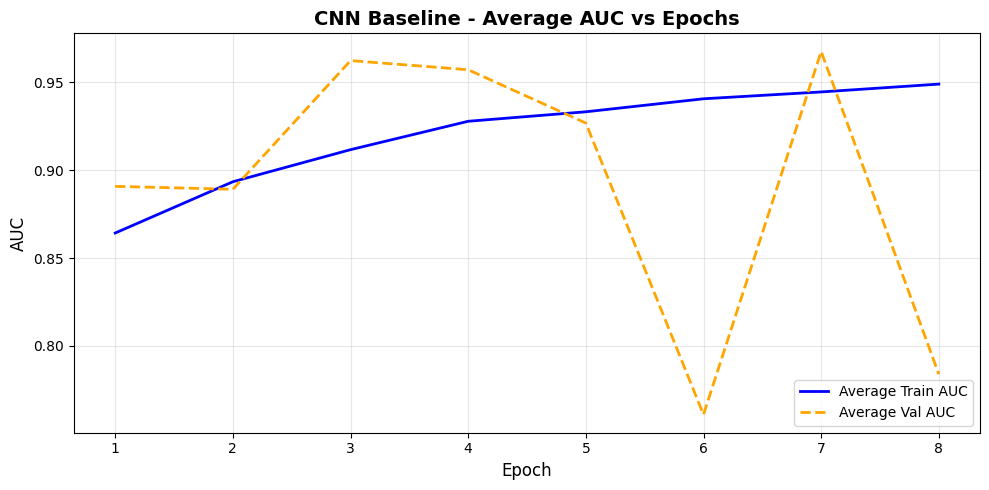

AUC curves saved: model_1_cnn_auc_curve.png


In [11]:
# Plot Average AUC curves
plt.figure(figsize=(10, 5))
avg_auc, eps = get_avg_history(fold_histories, 'auc')
avg_val_auc, _ = get_avg_history(fold_histories, 'val_auc')
plt.plot(eps, avg_auc, label='Average Train AUC', linewidth=2, color='blue')
plt.plot(eps, avg_val_auc, '--', label='Average Val AUC', linewidth=2, color='orange')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('CNN Baseline - Average AUC vs Epochs', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_1_cnn_auc_curve.png', dpi=150, bbox_inches='tight')
plt.show()
print('AUC curves saved: model_1_cnn_auc_curve.png')

## 9. Cross-Validation Results Summary

In [12]:
# Results dataframe
results_df = pd.DataFrame(fold_results)
print("\n" + "="*60)
print("3-FOLD CROSS-VALIDATION RESULTS")
print("="*60)
print(results_df.to_string(index=False))

# Calculate mean and std
print("\n" + "-"*60)
print("AVERAGE METRICS (Mean ± Std)")
print("-"*60)
for metric in ['accuracy', 'auc', 'precision', 'recall', 'f1']:
    mean_val = results_df[metric].mean()
    std_val = results_df[metric].std()
    print(f"{metric.capitalize():12}: {mean_val:.4f} ± {std_val:.4f}")

print(f"\nTotal Training Time: {total_training_time:.2f}s ({total_training_time/60:.2f} min)")


3-FOLD CROSS-VALIDATION RESULTS
 fold  accuracy      auc  precision   recall       f1  training_time
    1  0.853211 0.952191   0.844164 0.983771 0.908637     131.613182
    2  0.918005 0.966483   0.965992 0.921947 0.943456     113.680955
    3  0.909977 0.980468   0.985495 0.891892 0.936360     144.285357

------------------------------------------------------------
AVERAGE METRICS (Mean ± Std)
------------------------------------------------------------
Accuracy    : 0.8937 ± 0.0353
Auc         : 0.9664 ± 0.0141
Precision   : 0.9319 ± 0.0766
Recall      : 0.9325 ± 0.0468
F1          : 0.9295 ± 0.0184

Total Training Time: 389.83s (6.50 min)


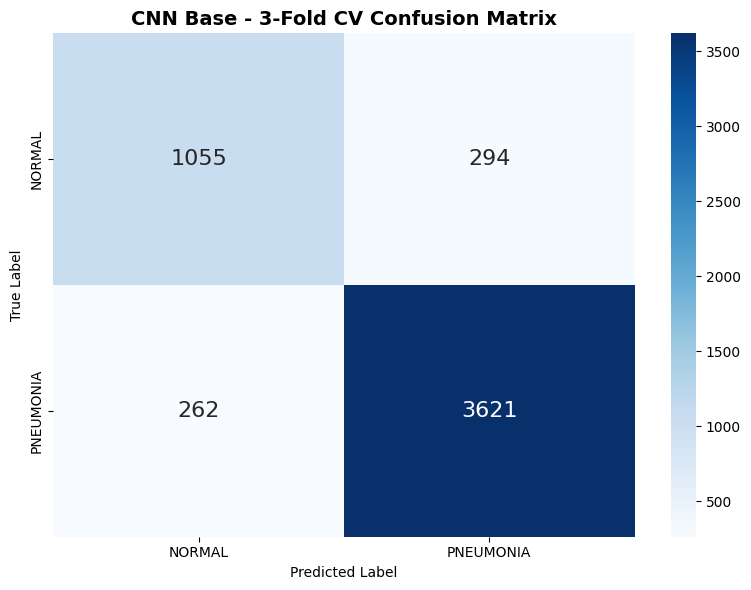


Overall Classification Report (CV):
              precision    recall  f1-score   support

      NORMAL       0.80      0.78      0.79      1349
   PNEUMONIA       0.92      0.93      0.93      3883

    accuracy                           0.89      5232
   macro avg       0.86      0.86      0.86      5232
weighted avg       0.89      0.89      0.89      5232



In [13]:
# Overall CV confusion matrix
cm = confusion_matrix(all_val_labels, all_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            annot_kws={'size': 16})
plt.title('CNN Base - 3-Fold CV Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('model_1_cnn_cv_confusion_matrix.png', dpi=150)
plt.show()

# Classification report
print("\nOverall Classification Report (CV):")
print(classification_report(all_val_labels, all_val_preds, target_names=CLASS_NAMES))

## 10. Ensemble Prediction on Test Set

**Strategy:** Load all 3 fold models, predict on test set, and average predictions for better robustness.

In [14]:
print("="*60)
print("ENSEMBLE PREDICTION - Loading all 3 fold models")
print("="*60)

# Load all 3 models
ensemble_models = []
for fold in range(1, N_FOLDS + 1):
    model_path = f'model_1_cnn_fold_{fold}.keras'
    print(f"Loading {model_path}...")
    model = keras.models.load_model(model_path)
    ensemble_models.append(model)
print(f"\nLoaded {len(ensemble_models)} models for ensemble.")

ENSEMBLE PREDICTION - Loading all 3 fold models
Loading model_1_cnn_fold_1.keras...
Loading model_1_cnn_fold_2.keras...
Loading model_1_cnn_fold_3.keras...

Loaded 3 models for ensemble.


In [15]:
# Create test dataset
test_dataset = create_dataset(test_paths, test_labels, BATCH_SIZE, augment=False, shuffle=False)

# Predict with each model
print("\nMaking predictions with each model...")
all_test_preds = []
for i, model in enumerate(ensemble_models):
    print(f"  Predicting with Fold {i+1} model...")
    preds = model.predict(test_dataset, verbose=0)
    all_test_preds.append(preds)
    print(f"    Mean prediction: {np.mean(preds):.4f}")

# Average predictions (Ensemble)
print("\nAveraging predictions from all 3 models...")
ensemble_preds_proba = np.mean(all_test_preds, axis=0)
ensemble_preds = (ensemble_preds_proba > 0.5).astype(int).flatten()

print(f"Ensemble mean prediction: {np.mean(ensemble_preds_proba):.4f}")


Making predictions with each model...
  Predicting with Fold 1 model...
    Mean prediction: 0.8542
  Predicting with Fold 2 model...
    Mean prediction: 0.7560
  Predicting with Fold 3 model...
    Mean prediction: 0.6594

Averaging predictions from all 3 models...
Ensemble mean prediction: 0.7565


In [16]:
# Calculate ensemble test metrics
test_acc = accuracy_score(test_labels, ensemble_preds)
test_auc = roc_auc_score(test_labels, ensemble_preds_proba)
test_precision = precision_score(test_labels, ensemble_preds)
test_recall = recall_score(test_labels, ensemble_preds)
test_f1 = f1_score(test_labels, ensemble_preds)

# Specificity and Sensitivity
tn, fp, fn, tp = confusion_matrix(test_labels, ensemble_preds).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("\n" + "="*60)
print("ENSEMBLE TEST SET RESULTS")
print("="*60)
print(f"Accuracy:    {test_acc:.4f}")
print(f"AUC-ROC:     {test_auc:.4f}")
print(f"Precision:   {test_precision:.4f}")
print(f"Recall:      {test_recall:.4f}")
print(f"F1-Score:    {test_f1:.4f}")
print(f"Sensitivity: {sensitivity:.4f} (Pneumonia detection)")
print(f"Specificity: {specificity:.4f} (Normal detection)")


ENSEMBLE TEST SET RESULTS
Accuracy:    0.8526
AUC-ROC:     0.9496
Precision:   0.8197
Recall:      0.9795
F1-Score:    0.8925
Sensitivity: 0.9795 (Pneumonia detection)
Specificity: 0.6410 (Normal detection)


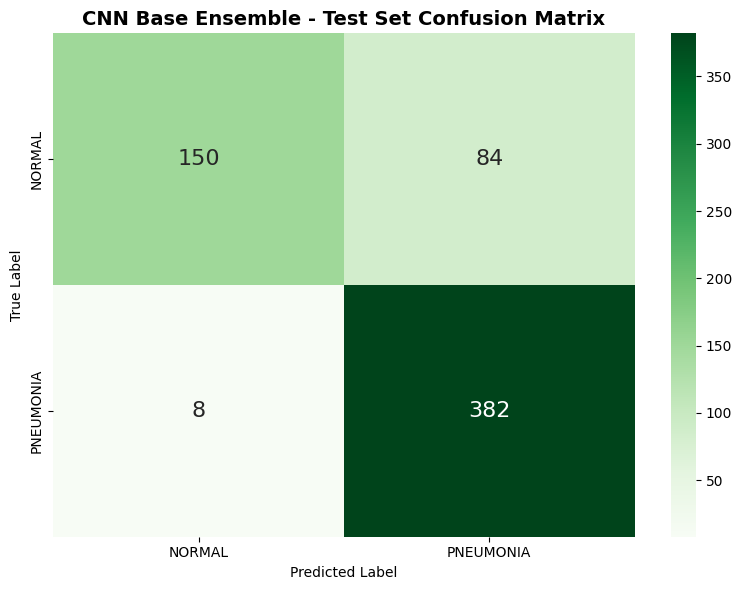


Test Set Classification Report (Ensemble):
              precision    recall  f1-score   support

      NORMAL       0.95      0.64      0.77       234
   PNEUMONIA       0.82      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.87      0.85      0.84       624



In [17]:
# Test set confusion matrix
cm_test = confusion_matrix(test_labels, ensemble_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            annot_kws={'size': 16})
plt.title('CNN Base Ensemble - Test Set Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('model_1_cnn_ensemble_test_confusion_matrix.png', dpi=150)
plt.show()

print("\nTest Set Classification Report (Ensemble):")
print(classification_report(test_labels, ensemble_preds, target_names=CLASS_NAMES))

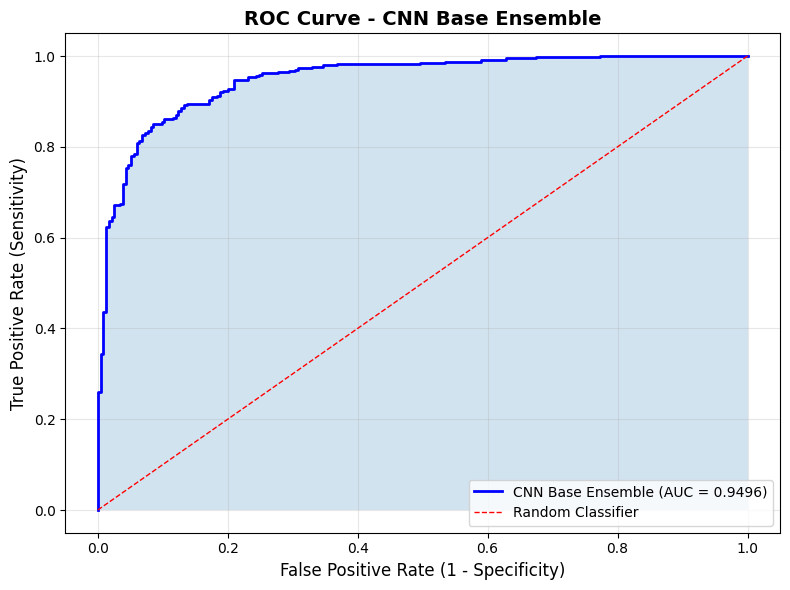

In [18]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, ensemble_preds_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'CNN Base Ensemble (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Classifier')
plt.fill_between(fpr, tpr, alpha=0.2)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC Curve - CNN Base Ensemble', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_1_cnn_ensemble_roc_curve.png', dpi=150)
plt.show()

## 11. Save Final Results

In [19]:
# Save all results to a summary file
final_results = {
    'model_name': 'CNN Base (From Scratch) - Ensemble',
    'architecture': 'VGG-like: 3 Conv Blocks (32→64→128) + GAP + Dense(128) + Dense(1)',
    'ensemble_strategy': 'Average predictions from 3 fold models',
    'image_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'n_folds': N_FOLDS,
    'max_epochs': EPOCHS,
    'early_stopping_patience': PATIENCE,
    'total_training_time_seconds': total_training_time,
    'total_training_time_minutes': total_training_time / 60,
    'cv_results': {
        'accuracy_mean': float(results_df['accuracy'].mean()),
        'accuracy_std': float(results_df['accuracy'].std()),
        'auc_mean': float(results_df['auc'].mean()),
        'auc_std': float(results_df['auc'].std()),
        'f1_mean': float(results_df['f1'].mean()),
        'f1_std': float(results_df['f1'].std()),
    },
    'test_results_ensemble': {
        'accuracy': float(test_acc),
        'auc': float(test_auc),
        'precision': float(test_precision),
        'recall': float(test_recall),
        'f1': float(test_f1),
        'sensitivity': float(sensitivity),
        'specificity': float(specificity)
    }
}

# Save to JSON
with open('model_1_cnn_ensemble_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("Results saved to model_1_cnn_ensemble_results.json")
print("\n" + "="*60)
print("MODEL 1: CNN BASE ENSEMBLE - TRAINING COMPLETE")
print("="*60)

Results saved to model_1_cnn_ensemble_results.json

MODEL 1: CNN BASE ENSEMBLE - TRAINING COMPLETE
